In [31]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm, eigh
from tqdm import tqdm
%matplotlib widget

# Electric field functions
# Electric field functions
def E_omega(t, E0_au, omega_au, t0_au, tau_au, phi1):
    # Set the time limit to 3 standard deviations (tau_au)
    t_limit = 3 * tau_au
    time_abs = np.abs(t - t0_au)
    
    return np.where(time_abs < t_limit, 
                    E0_au * np.exp(-((t - t0_au) / tau_au) ** 2) * ((np.cos(omega_au * t + phi1))**2), 
                    0)

# Given energy values in eV
omega_s_eV, omega_p_eV = -24.6, -3.4
#omega_s_eV, omega_p_eV = 0, 21.2
omega_s, omega_p = omega_s_eV*0.0367493, omega_p_eV*0.0367493
d_sp = 0.45
# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0],
    [0, omega_p],
], dtype=complex)

# Hamiltonian function
def hamiltonian(E_om):
    return np.array([
        [0, d_sp * E_om],
        [d_sp * E_om, 0]
    ], dtype=complex)
# Time array(in fs)
start_time = -400
stop_time = 400



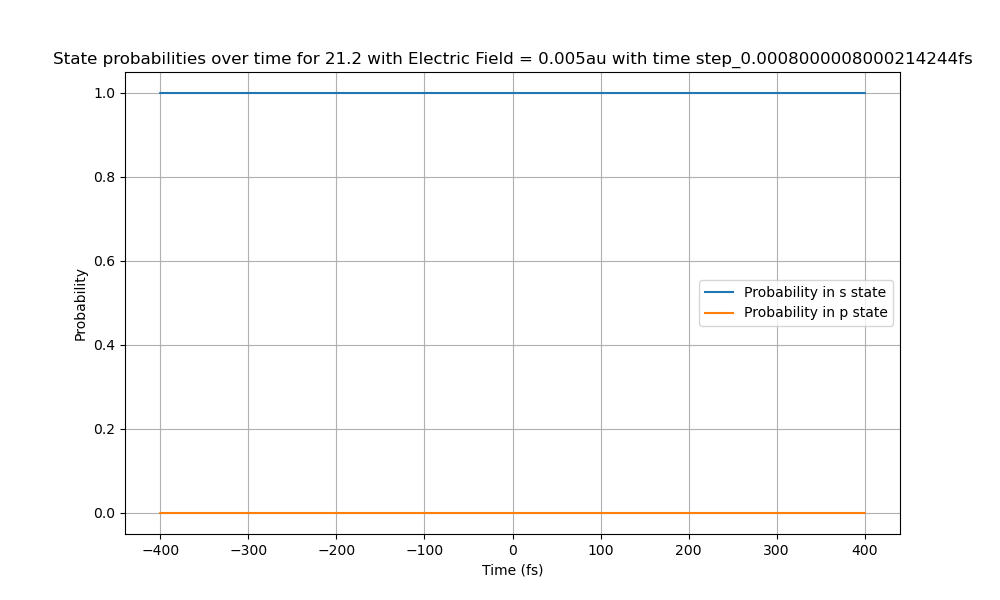

In [32]:

steps = 1000000 # steps
t_values_SI = np.linspace(start_time, stop_time, steps)     # Time array in femtoseconds
t_values = t_values_SI*41 # Time array in atomic units
#print(f"Time array is from {t_values[0]} to {t_values[-1]} with {steps} steps")
dt = t_values[1] - t_values[0]


# Electric Field
E0_SI = 620 # V/m
#E0_au = E0_SI*5.14220652*10**-11
E0_au = 0.005
omega_eV = 21.2
omega_au = omega_eV*0.0367493
phi1 = np.pi/2
tau = 50  # fs
tau_au = tau*41
t0 = 0 # fs
t0_au = t0*41

# Initial state
psi_0 = np.array([1.0, 0.0], dtype=complex)
psi_t_list = [psi_0]

for index in range(len(t_values)-1):
    t = t_values[index]
    #print(f'time is {t} for index {index}')
    E_omega_value = E_omega(t, E0_au, omega_au, t0_au, tau_au, phi1)
    Hamil_t = hamiltonian(E_omega_value)
    U0_half_dt = expm(-1j * H0 * dt / 2)
    psi_dt = psi_t_list[index]
    #print(f'psi_dt: {psi_dt}')
    psi_0_U0 = np.dot(U0_half_dt, psi_dt)
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = np.linalg.eigh(Hamil_t)
    assert np.allclose(np.dot(eigenvectors.T.conj(), eigenvectors), np.eye(len(Hamil_t))), "Eigenvectors are not unitary"
    #print(f'eigenvalues: {eigenvalues}')
    #print(f'eigenvectors: {eigenvectors}')
    # Transform the initial wave function to the eigenbasis
    psi_0_eigenbasis = np.dot(eigenvectors.T.conj(), psi_0_U0)
    #print(f'psi_0_eigenbasis: {psi_0_eigenbasis}')
    # Compute the time evolution in the eigenbasis
    U_t = np.diag(np.exp(-1j * eigenvalues * dt ))
    #print(f'U_t: {U_t}')
    psi_t_eigenbasis = np.dot(U_t, psi_0_eigenbasis)
    #print(f'psi_t_eigenbasis: {psi_t_eigenbasis}')

    # Transform back to the original basis
    psi_t = np.dot(eigenvectors, psi_t_eigenbasis)
    psi_t_U0 = np.dot(U0_half_dt, psi_t)
    #print(f'psi_t: {psi_t}')
    #print(f'psi_t_U0: {psi_t_U0}')
    psi_t_list.append(psi_t_U0)  # Store the result
#print(f'psi_t_list: {psi_t_list}')

# Convert the list to a NumPy array for further processing
psi_t_array = np.array(psi_t_list)

prob_s = np.abs(np.array(psi_t_array)[:,0])**2
prob_p = np.abs(np.array(psi_t_array)[:, 1])**2

title = f"State probabilities over time for {omega_eV} with Electric Field = {E0_au}au with time step_{dt/41}fs"

plt.figure(figsize=(10, 6))
plt.plot(t_values_SI, prob_s, label='Probability in s state')
plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.title(title)
plt.xlabel('Time (fs)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
plt.savefig(f"{title}.png")
plt.show()

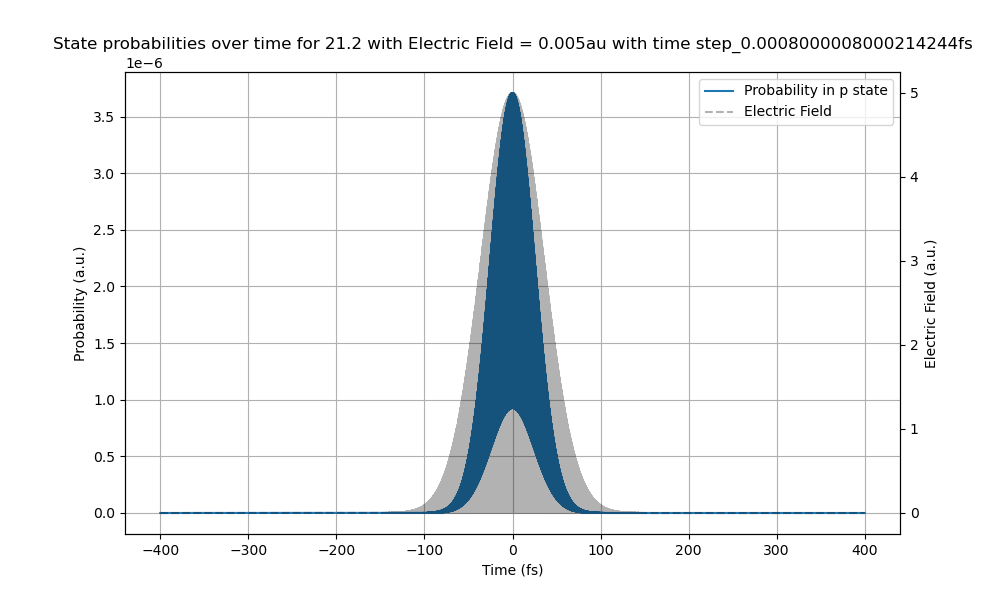

In [33]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create secondary y-axis for the electric field
ax2 = ax1.twinx()
ax2.plot(t_values_SI, E_omega(t_values, E0_au, omega_au, t0_au, tau_au, phi1) * 1000, label='Electric Field', color='black', linestyle='dashed', alpha=0.3)

ax2.set_ylabel('Electric Field (a.u.)')

# Plot probability states on primary y-axis (after electric field for normal color)
#ax1.plot(t_values_SI, prob_s, label='Probability in s state')
ax1.plot(t_values_SI, prob_p, label='Probability in p state')

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('Probability (a.u.)')
ax1.grid(which='both')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title(title)
plt.savefig(f"{title}_with_Electric_field.png")
plt.show()


In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, FloatSlider

# Parameters
Np = 1024
omega = np.linspace(-10, 10, Np, endpoint=False)
deltat = 2 * np.pi / 20
tlimit = deltat * Np / 2
time = np.linspace(-tlimit, tlimit, Np, endpoint=False)

# Function to generate plots
def plot_func(owidth, twidth, omega0, xlim, xlim2, random):
    global ftime, fomega, fphase

    # Random Phases and Fourier Transforms
    if random == 1 or ('fphase' not in globals()):
        fphase = (np.random.rand(Np) * 2 - 1) * np.pi
    fomega = 1.5 * np.exp(-(omega - omega0) ** 2 / owidth ** 2 + fphase * 1j)
    ftime = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(fomega)))
    tFilter = np.exp(-time ** 2 / twidth ** 2)
    ftime2 = ftime * tFilter
    fomega2 = np.fft.fftshift(np.fft.fft(np.fft.fftshift(ftime2)))

    # Create subplots
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=('Spectrum Initial', 'Spectrum Final', 'Temporal Field Initial', 'Temporal Field Final'))

    # Spectrum Initial
    fig.add_trace(go.Scatter(x=omega, y=fphase, mode='lines', name='Random Phase', opacity=0.3), row=1, col=1)
    fig.add_trace(go.Scatter(x=omega, y=np.abs(fomega)**2, mode='lines', name='Spectrum Initial', line=dict(width=2)), row=1, col=1)

    # Temporal Field Initial
    fig.add_trace(go.Scatter(x=time, y=np.real(ftime), mode='lines', name='Temporal Field Initial'), row=2, col=1)

    # Spectrum Final
    fig.add_trace(go.Scatter(x=omega, y=np.abs(fomega2)**2, mode='lines', name='Spectrum Final'), row=1, col=2)

    # Temporal Field Final
    fig.add_trace(go.Scatter(x=time, y=np.real(ftime2), mode='lines', name='Temporal Field Final'), row=2, col=2)
    fig.add_trace(go.Scatter(x=time, y=tFilter * max(abs(ftime2)), mode='lines', name='Time Filter', line=dict(dash='dash')), row=2, col=2)

    # Update axes limits and titles
    fig.update_xaxes(title_text='Frequency (ω)', range=[-0.5, xlim2], row=1, col=1)
    fig.update_yaxes(title_text='Amplitude', range=[-3.2, 3.2], row=1, col=1)

    fig.update_xaxes(title_text='Frequency (ω)', range=[-0.5, xlim2], row=1, col=2)
    fig.update_xaxes(title_text='Time', range=[-xlim, xlim], row=2, col=1)
    fig.update_xaxes(title_text='Time', range=[-xlim, xlim], row=2, col=2)

    # Update layout
    fig.update_layout(height=800, width=1100, title_text='Fourier Transform Analysis', showlegend=True)

    # Show the figure
    fig.show()

# Interactive Widgets
interact(plot_func,
         owidth=FloatSlider(value=.5, min=.1, max=1, step=0.01, description='Omega Width'),
         omega0=FloatSlider(value=1.5, min=0.01, max=4.0, step=0.01, description='Omega 0'),
         twidth=FloatSlider(value=50, min=.1, max=1000, step=0.01, description='Time Width'),
         xlim=FloatSlider(value=200, min=1, max=300, step=0.01, description='X Lim'),
         xlim2=FloatSlider(value=4, min=1, max=10, step=0.01, description='X Lim 2'),
         random=FloatSlider(value=1, min=0, max=1, step=1, description='Random Phases')
        )


interactive(children=(FloatSlider(value=0.5, description='Omega Width', max=1.0, min=0.1, step=0.01), FloatSli…

<function __main__.plot_func(owidth, twidth, omega0, xlim, xlim2, random)>